# Improved CNN (v2)

This CNN is based off the original improved CNN. However, the goal for this one was to maintain (or improve)
training accuracy while reducing model complexity and overfitting.

## Setup

Again, we start by importing modules and (down)loading data.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from pathlib import Path
import gdown

from tqdm.notebook import tqdm, trange
print = tqdm.write

In [2]:
from typing import Type

RESISC45_DIR = Path("..") / "NWPU-RESISC45"
if not RESISC45_DIR.exists():
    gdown.download(
        id="1nd0R9iljzkWd7Hhfyp2tH55KxAsKrzYj",
        output="./NWPU-RESISC45.rar",
    )
    !unrar x -inul ./NWPU-RESISC45.rar
    !mv NWPU-RESISC45 ..

### Statistics

We now perform some quick statistics on the data $-$ specifically, finding the mean and standard deviation.

In [3]:
def get_mean_and_std():
    """Log the mean and standard deviation of the RESISC45 data."""
    # load in the data
    transformations = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    dataset = ImageFolder(root=RESISC45_DIR, transform=transformations)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    # Iterate through the dataset
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    # Divide by number of samples and print results
    mean /= total_samples
    std /= total_samples

    print(f"Mean: {[round(i, 4) for i in mean.tolist()]}")
    print(f"Std: {[round(i, 4) for i in std.tolist()]}")


get_mean_and_std()

# Learning

We now will train our model.

## Setup and Hyperparameters

First, we define some basic hyperparameters, as shown below. We also find
which device we are training on. Then, we load and normalize the data, and
split it into train and test datasets. Finally, we define and create our neural network.

The main changes from the previous models are:
1. We now have 6 CNN layers, going from big to small (rather than small to big).
2. BatchNorm has been replaced by Dropout.
3. There are two linear layers at the end, both narrowing, but we still have a quarter of the parameters of the original models.

In [4]:
mean = (0.3680, 0.3810, 0.3436)
std = (0.1454, 0.1356, 0.1320)

# Test/train split
train_ratio = 0.8
test_ratio = 0.2

# Learning settings
batch_size = 64
learning_rate = 0.0003

channel_sizes = (32, 16, 8)
linear_sizes = (8712, 256)

normalizer = nn.Identity
model_name = "icnn_2"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Loading and normalizing the data.

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = ImageFolder(root=RESISC45_DIR, transform=transformations)
classes = dataset.class_to_idx

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [6]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(
        self, 
        linear_sizes, 
        channel_sizes, 
        activation=F.relu,
        norm: Type[nn.Module] = nn.BatchNorm2d
    ):
        super().__init__()
        
        self.linear_sizes = linear_sizes
        self.activation = activation
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.25)
        
        c1, c2, c3 = channel_sizes
        
        # First convolution
        self.conv1 = nn.Conv2d(3, c1, kernel_size=3, padding=1)
        self.norm1 = norm(c1)

        self.conv2 = nn.Conv2d(c1, c1, kernel_size=3, padding=1)
        self.norm2 = norm(c1)

        # Second convolution
        self.conv3 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.norm3 = norm(c2)
        
        self.conv4 = nn.Conv2d(c2, c2, kernel_size=2, padding=1)
        self.norm4 = norm(c2)
        
        # Third convolution
        self.conv5 = nn.Conv2d(c2, c3, kernel_size=2, padding=1)
        self.norm5 = norm(c3)
        
        self.conv6 = nn.Conv2d(c3, c3, kernel_size=2, padding=1)
        self.norm6 = norm(c3)

        # Linear
        lin0, lin1 = linear_sizes

        self.fc1 = nn.Linear(lin0, lin1)
        self.fc2 = nn.Linear(lin1, 45)

    def forward(self, x):
        batch_size = x.size(0)
        
        activation = self.activation
        maxpool = self.pool
        dropout = self.dropout
        
        # First convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm1(self.conv1(x))
        x = activation(x)
        x = dropout(x)
        
        x = self.norm2(self.conv2(x))
        x = activation(x)
        
        x = maxpool(x)
        x = dropout(x)
        
        # Second convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm3(self.conv3(x))
        x = activation(x)
        x = dropout(x)
        
        x = self.norm4(self.conv4(x))
        x = activation(x)
        
        x = maxpool(x)
        x = dropout(x)
        
        # Third convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm5(self.conv5(x))
        x = activation(x)
        x = dropout(x)
        
        x = self.norm6(self.conv6(x))
        x = activation(x)
        
        x = maxpool(x)
        x = dropout(x)

        # Linear
        x = x.reshape(batch_size, self.linear_sizes[0])
        
        x = activation(self.fc1(x))
        x = dropout(x)

        x = self.fc2(x)

        return x

# Instantiate a neural network model 
model = Network(linear_sizes, channel_sizes, norm=normalizer)

### Training

We now enter the training phase of the notebook. First, we create our loss function and optimizer
(another hyperparameter). We chose the adam optimzier as it works well, with a small weight decay
to help with overfitting. We then define helper functions to train our model: one for saving the model,
two for testing train/test accuracy. Finally, we create our main training loop.

In [7]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [8]:
# Function to save the model
def save_model():
    path = f"{model_name}_best.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def compute_train_accuracy():
    accuracy = 0.0
    total = 0
    
    # Turn on evaluation mode
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc="Train Acc"):
            images = images.to(device)
            labels = labels.to(device)

            # run the model on the test set to predict labels
            outputs = model(images)

            # the label with the highest value will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()

            total += labels.size(0)
    
    # compute the accuracy percentage over all test images
    accuracy = (accuracy / total) * 100
    return accuracy

def compute_test_accuracy():
    accuracy = 0.0
    total = 0

    # Turn on evaluation mode
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Acc"):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # run the model on the test set to predict labels
            outputs = model(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()

            total += labels.size(0)
    
    # compute the accuracy over all test images
    accuracy = (accuracy / total) * 100
    return accuracy 


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs, *, log_train_acc):
    train_acc_list = []
    test_acc_list = []
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Running on `{device}`.")
    
    # keep track of accuracy
    best_accuracy = 0.0

    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in trange(num_epochs, desc="Epochs"):  # loop over the dataset multiple times
        model.train()
        
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in tqdm(
            enumerate(train_loader, 0), 
            total=len(train_loader), 
            desc="Train"
        ):
            
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # predict classes using images from the training set
            outputs = model(images)

            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)

            # backpropagate the loss
            loss.backward()

            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 100 images
            running_loss += loss.item()     # extract the loss value
            if i % 100 == 99:
                # print every 100 images
                print(
                    f'[Epoch {epoch + 1:2d}]: '
                    f'Average loss at {i + 1:3d} iterations: {running_loss / (i + 1):.3f}'
                )

        end = len(train_loader)
        print(
            f'[Epoch {epoch + 1:2d}]: '
            f'Average loss at {end:3d} iterations: {running_loss / end:.3f}'
        )

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        if log_train_acc:
            train_accuracy = compute_train_accuracy()
            train_acc_list.append(train_accuracy)
            print(f'[Epoch {epoch + 1:2d}]: Train accuracy: {train_accuracy:.2f}%')

        test_accuracy = compute_test_accuracy()
        test_acc_list.append(test_accuracy)
        print(f'[Epoch {epoch + 1:2d}]: Test accuracy: {test_accuracy:.2f}%')
        
        # we want to save the model if the accuracy is the best
        if test_accuracy > best_accuracy:
            save_model()
            best_accuracy = test_accuracy
            
    return train_acc_list, test_acc_list

Finally, we train our model, for sixty epochs, and load the best model we have.
While training, we also saved our best accuracies.

This is split in 20/40 epoch groups to first test if the model has a good initialization,
and only if it does do we do the whole training.

In [ ]:
# Let's build our model
train_acc_list, test_acc_list = train(20, log_train_acc=True)
print('Finished Training')

# Test which classes performed well
compute_test_accuracy()

# Save final model
torch.save(model.state_dict(), f"{model_name}_final.pth")

In [14]:
# Finish up the next 40 epochs if all looks well.
train_acc_list2, test_acc_list2 = train(40, log_train_acc=True)
print('Finished Training')

# Test which classes performed well
compute_test_accuracy()

# Save final model
torch.save(model.state_dict(), f"{model_name}_final.pth")

Running on `cuda:0`.


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  1]: Average loss at 100 iterations: 1.690
[Epoch  1]: Average loss at 200 iterations: 1.682
[Epoch  1]: Average loss at 300 iterations: 1.693
[Epoch  1]: Average loss at 394 iterations: 1.700


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  1]: Train accuracy: 52.65%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  1]: Test accuracy: 37.62%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  2]: Average loss at 100 iterations: 1.655
[Epoch  2]: Average loss at 200 iterations: 1.666
[Epoch  2]: Average loss at 300 iterations: 1.672
[Epoch  2]: Average loss at 394 iterations: 1.677


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  2]: Train accuracy: 53.60%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  2]: Test accuracy: 37.54%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  3]: Average loss at 100 iterations: 1.632
[Epoch  3]: Average loss at 200 iterations: 1.634
[Epoch  3]: Average loss at 300 iterations: 1.633
[Epoch  3]: Average loss at 394 iterations: 1.645


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  3]: Train accuracy: 54.40%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  3]: Test accuracy: 37.32%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  4]: Average loss at 100 iterations: 1.600
[Epoch  4]: Average loss at 200 iterations: 1.608
[Epoch  4]: Average loss at 300 iterations: 1.607
[Epoch  4]: Average loss at 394 iterations: 1.610


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  4]: Train accuracy: 53.67%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  4]: Test accuracy: 37.56%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  5]: Average loss at 100 iterations: 1.568
[Epoch  5]: Average loss at 200 iterations: 1.571
[Epoch  5]: Average loss at 300 iterations: 1.580
[Epoch  5]: Average loss at 394 iterations: 1.582


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  5]: Train accuracy: 55.81%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  5]: Test accuracy: 38.32%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  6]: Average loss at 100 iterations: 1.534
[Epoch  6]: Average loss at 200 iterations: 1.536
[Epoch  6]: Average loss at 300 iterations: 1.553
[Epoch  6]: Average loss at 394 iterations: 1.553


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  6]: Train accuracy: 59.72%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  6]: Test accuracy: 40.02%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  7]: Average loss at 100 iterations: 1.499
[Epoch  7]: Average loss at 200 iterations: 1.493
[Epoch  7]: Average loss at 300 iterations: 1.502
[Epoch  7]: Average loss at 394 iterations: 1.514


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  7]: Train accuracy: 55.58%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  7]: Test accuracy: 38.40%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  8]: Average loss at 100 iterations: 1.483
[Epoch  8]: Average loss at 200 iterations: 1.490
[Epoch  8]: Average loss at 300 iterations: 1.496
[Epoch  8]: Average loss at 394 iterations: 1.502


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  8]: Train accuracy: 59.83%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  8]: Test accuracy: 40.30%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  9]: Average loss at 100 iterations: 1.414
[Epoch  9]: Average loss at 200 iterations: 1.443
[Epoch  9]: Average loss at 300 iterations: 1.455
[Epoch  9]: Average loss at 394 iterations: 1.460


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  9]: Train accuracy: 59.85%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  9]: Test accuracy: 39.46%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 10]: Average loss at 100 iterations: 1.413
[Epoch 10]: Average loss at 200 iterations: 1.430
[Epoch 10]: Average loss at 300 iterations: 1.441
[Epoch 10]: Average loss at 394 iterations: 1.445


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 10]: Train accuracy: 59.76%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 10]: Test accuracy: 38.44%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 11]: Average loss at 100 iterations: 1.417
[Epoch 11]: Average loss at 200 iterations: 1.417
[Epoch 11]: Average loss at 300 iterations: 1.416
[Epoch 11]: Average loss at 394 iterations: 1.422


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 11]: Train accuracy: 62.06%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 11]: Test accuracy: 40.52%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 12]: Average loss at 100 iterations: 1.394
[Epoch 12]: Average loss at 200 iterations: 1.394
[Epoch 12]: Average loss at 300 iterations: 1.400
[Epoch 12]: Average loss at 394 iterations: 1.402


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 12]: Train accuracy: 59.88%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 12]: Test accuracy: 38.41%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 13]: Average loss at 100 iterations: 1.347
[Epoch 13]: Average loss at 200 iterations: 1.364
[Epoch 13]: Average loss at 300 iterations: 1.373
[Epoch 13]: Average loss at 394 iterations: 1.376


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 13]: Train accuracy: 63.02%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 13]: Test accuracy: 40.38%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 14]: Average loss at 100 iterations: 1.352
[Epoch 14]: Average loss at 200 iterations: 1.346
[Epoch 14]: Average loss at 300 iterations: 1.356
[Epoch 14]: Average loss at 394 iterations: 1.360


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 14]: Train accuracy: 65.61%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 14]: Test accuracy: 40.83%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 15]: Average loss at 100 iterations: 1.313
[Epoch 15]: Average loss at 200 iterations: 1.311
[Epoch 15]: Average loss at 300 iterations: 1.320
[Epoch 15]: Average loss at 394 iterations: 1.326


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 15]: Train accuracy: 67.22%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 15]: Test accuracy: 41.10%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 16]: Average loss at 100 iterations: 1.301
[Epoch 16]: Average loss at 200 iterations: 1.294
[Epoch 16]: Average loss at 300 iterations: 1.299
[Epoch 16]: Average loss at 394 iterations: 1.304


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 16]: Train accuracy: 69.94%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 16]: Test accuracy: 42.41%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 17]: Average loss at 100 iterations: 1.295
[Epoch 17]: Average loss at 200 iterations: 1.277
[Epoch 17]: Average loss at 300 iterations: 1.280
[Epoch 17]: Average loss at 394 iterations: 1.288


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 17]: Train accuracy: 69.48%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 17]: Test accuracy: 41.92%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 18]: Average loss at 100 iterations: 1.229
[Epoch 18]: Average loss at 200 iterations: 1.243
[Epoch 18]: Average loss at 300 iterations: 1.248
[Epoch 18]: Average loss at 394 iterations: 1.254


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 18]: Train accuracy: 69.31%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 18]: Test accuracy: 41.10%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 19]: Average loss at 100 iterations: 1.185
[Epoch 19]: Average loss at 200 iterations: 1.207
[Epoch 19]: Average loss at 300 iterations: 1.236
[Epoch 19]: Average loss at 394 iterations: 1.240


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 19]: Train accuracy: 68.53%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 19]: Test accuracy: 40.86%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 20]: Average loss at 100 iterations: 1.198
[Epoch 20]: Average loss at 200 iterations: 1.200
[Epoch 20]: Average loss at 300 iterations: 1.204
[Epoch 20]: Average loss at 394 iterations: 1.214


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 20]: Train accuracy: 71.62%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 20]: Test accuracy: 42.06%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 21]: Average loss at 100 iterations: 1.148
[Epoch 21]: Average loss at 200 iterations: 1.169
[Epoch 21]: Average loss at 300 iterations: 1.181
[Epoch 21]: Average loss at 394 iterations: 1.183


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 21]: Train accuracy: 73.62%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 21]: Test accuracy: 42.49%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 22]: Average loss at 100 iterations: 1.122
[Epoch 22]: Average loss at 200 iterations: 1.140
[Epoch 22]: Average loss at 300 iterations: 1.153
[Epoch 22]: Average loss at 394 iterations: 1.165


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 22]: Train accuracy: 72.70%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 22]: Test accuracy: 42.19%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 23]: Average loss at 100 iterations: 1.121
[Epoch 23]: Average loss at 200 iterations: 1.144
[Epoch 23]: Average loss at 300 iterations: 1.140
[Epoch 23]: Average loss at 394 iterations: 1.142


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 23]: Train accuracy: 76.23%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 23]: Test accuracy: 42.48%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 24]: Average loss at 100 iterations: 1.077
[Epoch 24]: Average loss at 200 iterations: 1.102
[Epoch 24]: Average loss at 300 iterations: 1.118
[Epoch 24]: Average loss at 394 iterations: 1.123


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 24]: Train accuracy: 73.64%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 24]: Test accuracy: 42.57%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 25]: Average loss at 100 iterations: 1.114
[Epoch 25]: Average loss at 200 iterations: 1.109
[Epoch 25]: Average loss at 300 iterations: 1.108
[Epoch 25]: Average loss at 394 iterations: 1.108


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 25]: Train accuracy: 76.79%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 25]: Test accuracy: 42.95%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 26]: Average loss at 100 iterations: 1.079
[Epoch 26]: Average loss at 200 iterations: 1.063
[Epoch 26]: Average loss at 300 iterations: 1.066
[Epoch 26]: Average loss at 394 iterations: 1.074


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 26]: Train accuracy: 79.48%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 26]: Test accuracy: 44.94%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 27]: Average loss at 100 iterations: 1.025
[Epoch 27]: Average loss at 200 iterations: 1.051
[Epoch 27]: Average loss at 300 iterations: 1.060
[Epoch 27]: Average loss at 394 iterations: 1.065


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 27]: Train accuracy: 75.90%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 27]: Test accuracy: 42.19%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 28]: Average loss at 100 iterations: 1.017
[Epoch 28]: Average loss at 200 iterations: 1.035
[Epoch 28]: Average loss at 300 iterations: 1.041
[Epoch 28]: Average loss at 394 iterations: 1.045


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 28]: Train accuracy: 78.47%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 28]: Test accuracy: 43.46%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 29]: Average loss at 100 iterations: 1.013
[Epoch 29]: Average loss at 200 iterations: 1.009
[Epoch 29]: Average loss at 300 iterations: 1.016
[Epoch 29]: Average loss at 394 iterations: 1.019


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 29]: Train accuracy: 79.11%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 29]: Test accuracy: 42.95%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 30]: Average loss at 100 iterations: 0.976
[Epoch 30]: Average loss at 200 iterations: 0.979
[Epoch 30]: Average loss at 300 iterations: 0.997
[Epoch 30]: Average loss at 394 iterations: 1.005


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 30]: Train accuracy: 79.92%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 30]: Test accuracy: 42.94%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 31]: Average loss at 100 iterations: 0.980
[Epoch 31]: Average loss at 200 iterations: 0.978
[Epoch 31]: Average loss at 300 iterations: 0.985
[Epoch 31]: Average loss at 394 iterations: 0.987


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 31]: Train accuracy: 80.97%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 31]: Test accuracy: 44.49%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 32]: Average loss at 100 iterations: 0.949
[Epoch 32]: Average loss at 200 iterations: 0.957
[Epoch 32]: Average loss at 300 iterations: 0.963
[Epoch 32]: Average loss at 394 iterations: 0.972


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 32]: Train accuracy: 79.10%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 32]: Test accuracy: 42.79%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 33]: Average loss at 100 iterations: 0.930
[Epoch 33]: Average loss at 200 iterations: 0.940
[Epoch 33]: Average loss at 300 iterations: 0.947
[Epoch 33]: Average loss at 394 iterations: 0.945


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 33]: Train accuracy: 81.69%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 33]: Test accuracy: 43.73%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 34]: Average loss at 100 iterations: 0.909
[Epoch 34]: Average loss at 200 iterations: 0.909
[Epoch 34]: Average loss at 300 iterations: 0.924
[Epoch 34]: Average loss at 394 iterations: 0.932


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 34]: Train accuracy: 82.77%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 34]: Test accuracy: 43.95%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 35]: Average loss at 100 iterations: 0.868
[Epoch 35]: Average loss at 200 iterations: 0.895
[Epoch 35]: Average loss at 300 iterations: 0.903
[Epoch 35]: Average loss at 394 iterations: 0.915


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 35]: Train accuracy: 84.34%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 35]: Test accuracy: 43.94%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 36]: Average loss at 100 iterations: 0.887
[Epoch 36]: Average loss at 200 iterations: 0.890
[Epoch 36]: Average loss at 300 iterations: 0.886
[Epoch 36]: Average loss at 394 iterations: 0.896


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 36]: Train accuracy: 85.77%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 36]: Test accuracy: 45.22%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 37]: Average loss at 100 iterations: 0.865
[Epoch 37]: Average loss at 200 iterations: 0.873
[Epoch 37]: Average loss at 300 iterations: 0.882
[Epoch 37]: Average loss at 394 iterations: 0.893


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 37]: Train accuracy: 87.59%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 37]: Test accuracy: 45.68%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 38]: Average loss at 100 iterations: 0.845
[Epoch 38]: Average loss at 200 iterations: 0.862
[Epoch 38]: Average loss at 300 iterations: 0.862
[Epoch 38]: Average loss at 394 iterations: 0.868


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 38]: Train accuracy: 85.94%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 38]: Test accuracy: 43.73%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 39]: Average loss at 100 iterations: 0.840
[Epoch 39]: Average loss at 200 iterations: 0.844
[Epoch 39]: Average loss at 300 iterations: 0.846
[Epoch 39]: Average loss at 394 iterations: 0.851


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 39]: Train accuracy: 87.13%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 39]: Test accuracy: 44.27%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 40]: Average loss at 100 iterations: 0.809
[Epoch 40]: Average loss at 200 iterations: 0.811
[Epoch 40]: Average loss at 300 iterations: 0.810
[Epoch 40]: Average loss at 394 iterations: 0.818


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 40]: Train accuracy: 87.52%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 40]: Test accuracy: 45.35%
Finished Training


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

### Visualization

We now plot our training and testing accuracies across the epochs.

In [43]:
model_save = model

train_acc_list += train_acc_list2
test_acc_list += test_acc_list2

assert len(train_acc_list) == len(test_acc_list)
epochs = [x + 1 for x in range(len(train_acc_list))]

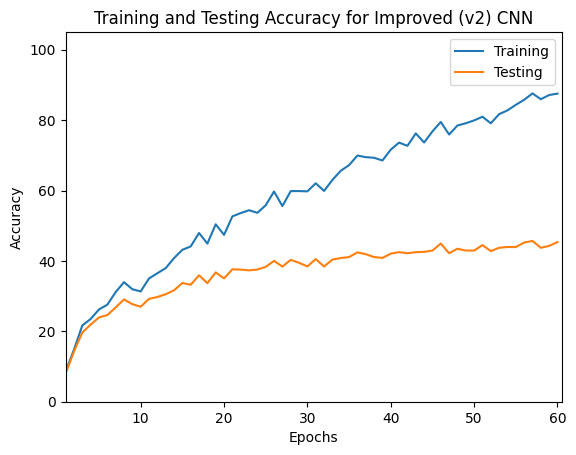

In [44]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_acc_list, label="Training")
plt.plot(epochs, test_acc_list, label="Testing")
plt.ylim(0, 105)
plt.xlim(1, len(epochs)+0.5)
plt.title("Training and Testing Accuracy for Improved (v2) CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Validation

Now that we've trained our model, we create some visualizations to help us validate the accuracy. 
Here, we are creating ag rid of images, and comparing the actual vs. predicted lables. This lets
us visualize what the model does right and what it does wrong.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def test_batch():
    class_list = list(classes.keys())

    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    show_image(torchvision.utils.make_grid(images))
   
    # Get a tuple of real labels
    real_labels = (class_list[labels[j]] for j in range(batch_size))
  
    # Let's see what if the model identifiers the  labels of those example
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    predicted_labels = (class_list[predicted[j]] for j in range(batch_size))
    
    print(f"{'Real':25s}| {'Predicted':25s}| Match")
    print('-' * 25 + '+' + '-' * 27 + '+' + '-' * 6)

    for real, pred in zip(real_labels, predicted_labels, strict=True):
        match_char = '✅' if real == pred else '❌'
        print(f"{real:25s}|  {pred:25s}| {match_char}")

In [37]:
# Let's load the model we just created and test the accuracy per label
model = Network(linear_sizes, channel_sizes, norm=normalizer)

model.load_state_dict(torch.load(f"{model_name}_best.pth"))
model.to(device)

Network(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): Identity()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): Identity()
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): Identity()
  (conv4): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm4): Identity()
  (conv5): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm5): Identity()
  (conv6): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm6): Identity()
  (fc1): Linear(in_features=8712, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=45, bias=True)
)

In [38]:
# Test which classes performed well
train_accuracy = compute_train_accuracy()
print(f'Best train accuracy: {train_accuracy:.2f}%')

test_accuracy = compute_test_accuracy()
print(f'Best test accuracy: {test_accuracy:.2f}%')

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

Best train accuracy: 87.59%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

Best test accuracy: 45.68%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


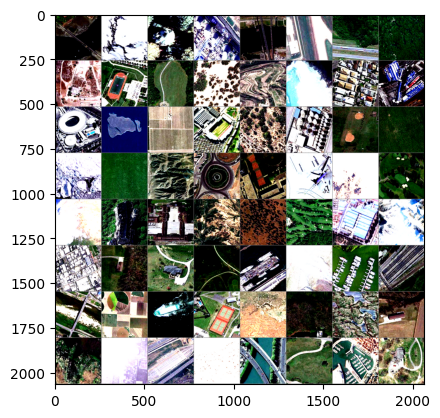

Real                     | Predicted                | Match
-------------------------+---------------------------+------
bridge                   |  bridge                   | ✅
snowberg                 |  airplane                 | ❌
church                   |  church                   | ✅
thermal_power_station    |  thermal_power_station    | ✅
bridge                   |  bridge                   | ✅
runway                   |  beach                    | ❌
freeway                  |  meadow                   | ❌
wetland                  |  wetland                  | ✅
palace                   |  sparse_residential       | ❌
ground_track_field       |  baseball_diamond         | ❌
meadow                   |  meadow                   | ✅
chaparral                |  chaparral                | ✅
terrace                  |  terrace                  | ✅
beach                    |  beach                    | ✅
dense_residential        |  dense_residential        | ✅
industrial_area         

In [39]:
# Show a sample of images
test_batch()